# Devoir 2: les réseaux convolutifs

L'objectif du présent travail est de vous familiaiser avec les réseaux de neurones convolutifs ainsi que leur architecture dans tensorflow. De plus, il vous permettra d'expérimenter les approches d'augmentation des données qui sont couramment utilisées en apprentissage profond. 

La tâche en est une de classification: à partir de la base de données CIFAR10, qui peut être instantiée directement à partir de tensorflow, vous devrez concevoir un classifieur qui permet de reconnaître correctement les 10 classes d'objets. Vous devrez vous servir des stratégies d'entraînement suivantes:

- apprentissage par curriculum (concevoir une tâche 'facile' et une tâche 'difficile' de sorte à vous servir des représentations cachées apprises lors de la résolution de la tâche facile comme valeurs initiales pour l'apprentissage de la tâche difficile)

- Augmentation des données (les fonctions nécessaires sont fournies dans le présent notebook) 

Bonus:

- utilisation du dropout dans les couches convolutives

- utilisation du taux d'apprentissage décroissant

Bon travail!


## Partie 1: acquisition et visualisation des données

In [191]:
# Importation des librairies
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
from tqdm import tqdm
from copy import deepcopy

In [192]:
# Importation des donnees
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

In [193]:
!pip install pillow
from PIL import Image
X_train.shape

(50000, 32, 32, 3)

In [194]:
Y_train.shape

(50000, 1)

In [195]:


def trasform_1h(Y,size=10):
    Y_h =np.zeros([Y.shape[0],size],dtype=int)
    for iy in range(Y.shape[0]):
        classe = int(Y[iy])
        vec_1h = [0]*size
        vec_1h[classe] = 1
        Y_h[iy] = vec_1h 
    return Y_h
def classify_animal_object(Y):
    i_animals = [0,1,8,9]
    Y_a_o =np.zeros([Y.shape[0],1],dtype=int)
    for i in range(Y.shape[0]):
        #print("Y-",Y[i,0])
        if Y[i,0] in i_animals:
            Y_a_o[i] = 1
    return Y_a_o
           

In [196]:
#Y_h = np.reshape(Y_h,[50000,10])
#Y_h_test = np.reshape(Y_h_test,[10000,10])

## Partie 2: Fonctions de manipulation des données

### Mise à l'échelle

In [197]:
def image_echelle(img, fac):
    
    # Préparation
    largeur, hauteur, canaux = img.shape
    max_l = int( largeur * fac )
    max_h = int( hauteur * fac )
    init_l= np.random.randint( int( largeur * (1 - fac) ) )
    init_h= np.random.randint( int( hauteur * (1 - fac) ) )
    
    # Sélection d'une portion de l'image
    n_img = img[init_l : max_l, init_h : max_h, :]
    # Restauration de la taille initiale
    IM = Image.fromarray(n_img)
    IM = IM.resize( (largeur, hauteur), Image.ANTIALIAS )
    
    return np.array(IM)
    

In [198]:
X_train.shape

(50000, 32, 32, 3)

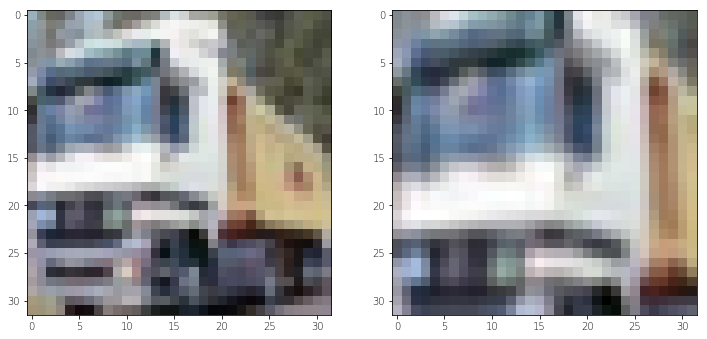

In [199]:
X_train.shape
hF = plt.figure(figsize=(12,6))
Ax1 = hF.add_subplot(121)
Ax1.imshow(X_train[1, :, :, :])
Ax2 = hF.add_subplot(122)
Ax2.imshow( image_echelle(X_train[1, :, :, :], 0.8))


In [200]:
#from tqdm import tqdm_notebook
#for r in tqdm_notebook(X_train):
#    result = np.reshape(image_echelle(r,0.7),[1,32,32,3])
#    X_train += result

In [201]:
X_train.shape

(50000, 32, 32, 3)

In [202]:
X_train.shape

(50000, 32, 32, 3)

### Translation

In [203]:
def image_translation(img, fac):
    
    # Préparation
    a = e = 1
    b = d = 0

    largeur, hauteur, canaux = img.shape
    c= np.random.randint( -int( largeur * fac ), int( largeur * fac ) )
    f= np.random.randint( -int( hauteur * fac ), int( hauteur * fac ) )
    
    # Tranlsation
    IM = Image.fromarray(img)
    IM = IM.transform(IM.size, Image.AFFINE, (a, b, c, d, e, f))
    
    return np.array(IM)

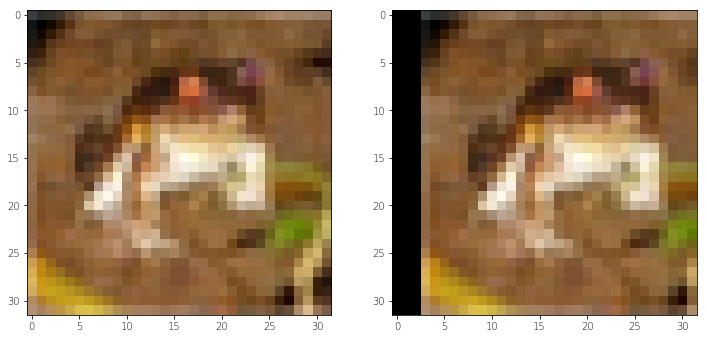

In [204]:
X_train.shape
hF = plt.figure(figsize=(12,6))
Ax1 = hF.add_subplot(121)
Ax1.imshow(X_train[0, :, :, :])
Ax2 = hF.add_subplot(122)
Ax2.imshow( image_translation(X_train[0, :, :, :], 0.2))

### Rotation

In [205]:
def image_rotation(img, angle):
    
    # Préparation
    IM = Image.fromarray(img)
    IM = IM.rotate(angle)
    
    return np.array(IM)

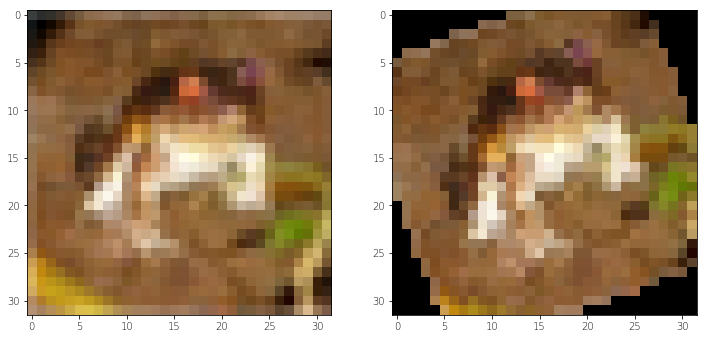

In [206]:
X_train.shape
hF = plt.figure(figsize=(12,6))
Ax1 = hF.add_subplot(121)
Ax1.imshow(X_train[0, :, :, :])
Ax2 = hF.add_subplot(122)
Ax2.imshow( image_rotation(X_train[0, :, :, :], 20))

### Inversion

In [207]:
def image_inversion(img, proba_h, proba_v):
    
    # Préparation
    if proba_h>np.random.random():
        if proba_v>np.random.random():
            img = img[::-1, ::-1, :]
        else:
            img = img[:, ::-1, :]
    elif proba_v>np.random.random():
        img = img[::-1, :, :]
    
    return np.array(img)

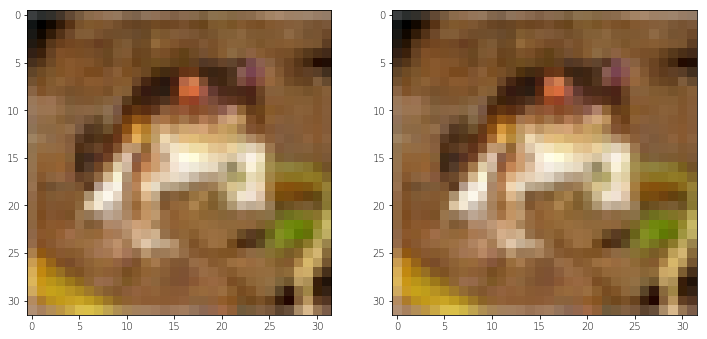

In [208]:
X_train.shape
hF = plt.figure(figsize=(12,6))
Ax1 = hF.add_subplot(121)
Ax1.imshow(X_train[0, :, :, :])
Ax2 = hF.add_subplot(122)
Ax2.imshow( image_inversion(X_train[0, :, :, :], 0, 0))

In [209]:
def list_fonction_augmentation():
    f1 = lambda x : image_echelle(x,0.8 )
    f2 = lambda x : image_translation(x,0.2 )
    f3 = lambda x : image_rotation(x,20)
    f4 = lambda x : image_inversion(x,0,0)
    f5 = lambda x : x
    return [f1,f2,f3,f4,f5]

In [210]:
def executer_fonction_augmentation(X,entrainer,train_step, cout , y_1h,params,step,cout_actuel):
    trans_batch = np.zeros([X[:, :, :, :].shape[0],32,32,3])
    augmentations = []
    qtd = 0
    c_moyen = 0 
    _,c = entrainer(train_step,cout,X/255,y_1h,params,step)
    c_moyen += c
    for f in list_fonction_augmentation() :
        if np.random.random() <0.25:
            qtd += 1
            for r in range(X[:, :, :, :].shape[0]):
                trans_batch[r] = np.reshape(f(X[r, :, :, :]), [-1, 32, 32, 3])
            _,c = entrainer(train_step,cout,trans_batch/255,y_1h,params,step)
            c_moyen += c
    if qtd == 0 :
        return cout_actuel
    else:
        return c_moyen /qtd


## Partie 3: Construction du réseau

In [211]:
vec_permutation = np.random.permutation(50000)
vec_permutation


array([ 7906, 29815, 47720, ...,  9776, 20799, 43810])

In [212]:
import math


In [213]:
def construire_reseau():
    # signal d'entree X: images de taille 32x32
    X = tf.placeholder(tf.float32, [None, 32, 32, 3],"X")
    # Les classes des images
    Y_reel_facile = tf.placeholder(tf.float32, [None, 2],name="Y_reel_facile")
    Y_reel_difficile = tf.placeholder(tf.float32, [None, 10],name="Y_reel_difficile")
    # Probabilité de garder la valeur d'une unité cachée: utilisée par le dropout 
    pkeep = tf.placeholder(tf.float32,name="pkeep")
    # Pas de décroissance du taux d'apprentissage
    step = tf.placeholder(tf.int32,name="step")

    # 1ere couche de convolution
    K  = 6  # nombre de noyaux de convolution
    W1 = tf.Variable(tf.truncated_normal([3, 3, 3, K], stddev=0.1))  
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
    stride = 1  # format de sortie: 28x28
    Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
    YY1= tf.nn.dropout(Y1, pkeep)  
    # 2eme couche de convolution   
    L  = 12  # nombre de noyaux de convolution
    W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
    stride = 2  #format de sortie: 17x17
    Y2 = tf.nn.relu(tf.nn.conv2d(YY1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
    conv1_pool = tf.nn.max_pool(Y2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)
    #print("y2",Y2)
    # 2eme couche de convolution   
    M  = 24  # nombre de noyaux de convolution
    W3 = tf.Variable(tf.truncated_normal([5, 5, L, M], stddev=0.1))
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))
    stride = 2  # format de sortie: 7x7
    Y3 = tf.nn.relu(tf.nn.conv2d(conv1_bn, W3, strides=[1, stride, stride, 1], padding='SAME') + B3,name='Y3')
    # La sortie de cette couche va etre connectee a une couche densément connecectée
    # il faut applatir le vecteur
    #print(Y3)
    conv4_pool = tf.nn.max_pool(Y3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    #print("conv4_bn",conv4_bn)
    YY = tf.reshape(conv4_bn, shape=[-1, 2 * 2 * M],name="YY")
    
    # 1ere couche densément connectée 
    N  = 200  
    W4 = tf.Variable(tf.truncated_normal([2 *2 * M, N], stddev=0.1))
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))
    Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
    YY4= tf.nn.dropout(Y4, pkeep)
    
    # 2eme couche densément connectée 
    W5 = tf.Variable(tf.truncated_normal([N, 2], stddev=0.1))
    B5 = tf.Variable(tf.constant(0.1, tf.float32, [2]))
    Ylogits_facile = tf.add( tf.matmul(YY4, W5), B5 )
    Y_facile = tf.nn.softmax(Ylogits_facile,name="Y_facile")
   
    W6 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
    B6 = tf.Variable(tf.constant(0.1, tf.float32, [10]))
    Ylogits_difficile = tf.add( tf.matmul(YY4, W6), B6 )
    Y_difficile = tf.nn.softmax(Ylogits_difficile,name="Y_dificille")
    # La fonction de cout utilisée pour la classification est l'entropie croisée
    cout_facile = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits_facile, labels=Y_reel_facile)
    cout_facile = tf.reduce_mean(cout_facile)*100
    
    # La fonction de cout utilisée pour la classification est l'entropie croisée
    cout_difficile = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits_difficile, labels=Y_reel_difficile)
    cout_difficile = tf.reduce_mean(cout_difficile)*100

    # Etape d'entrainement
    # the learning rate is: # 0.0001 + 0.003 * (1/e)^(step/2000)), i.e. exponential decay from 0.003->0.0001
    lr = 0.0001 +  tf.train.exponential_decay(0.003, step, 2000, 1/math.e)
    train_step_facile = tf.train.AdamOptimizer(lr).minimize(cout_facile)
    
    # Etape d'entrainement pour la tache difficile
    # the learning rate is: # 0.0001 + 0.003 * (1/e)^(step/2000)), i.e. exponential decay from 0.003->0.0001
    lr = tf.train.exponential_decay(0.001, step, 2000,.96)
    train_step_difficile = tf.train.AdamOptimizer(lr).minimize(cout_difficile)
    # Initialiser les variables 
    init = tf.global_variables_initializer()
    
    return X, Y_reel_facile, Y_reel_difficile, Y_facile, Y_difficile, pkeep, step, cout_facile, cout_difficile, train_step_facile, train_step_difficile, init


## Partie 4: Définition de la tâche facile

### La tâche facile est de classifier les images dans 2 groupes : objets ou animales

In [214]:
import sys
import random
hyperp = {'nb_iterations':10, 'taille_batch':100, 'pas_affichage':1, 'p_keep':0.75}
hist_count =[]
accuracies = np.zeros([2,10000])
def entrainer_reseau_facile(X1, Y1, sess,cout_facile, train_step_facile,  init, params,y_pred,X_test_task,Y_test_task):
    batch_ys_test_1h = trasform_1h(Y_test_task,size=2)
    batch_ys_test_1h = np.reshape(batch_ys_test_1h,[-1,2])
    
 
    
    # Lancer l'initialisation
   
    sess.run(init)

    error_train =[]
    error_test=[]
    # Définir les cycles d'entraînement
    couts = []
    trans_batch = np.zeros([params['taille_batch'],32,32,3])
    i_c =0
    cout_actuel = 0
    precisions = []
    for iter in range( params['nb_iterations'] ):
        cout_moyen  = 0
        
        total_batch = int( X1.shape[0]/params['taille_batch'] )
        # itérer sur l'ensemble des batchesprecision:{}".format(cout_moyen,tester_reseau(sess,y_pred,batch_xs,batch_ys))
        for i in range(total_batch):
           
           
            debut_batch = i*params['taille_batch']
            fin_batch   = debut_batch + params['taille_batch']
            batch_xs    = np.reshape( X1[debut_batch:fin_batch, :], [-1, 32, 32, 3] )

            batch_ys    = Y1[debut_batch:fin_batch]
            batch_ys_1h = trasform_1h(batch_ys,size=2)
            batch_ys_1h = np.reshape(batch_ys_1h,[100,2])
            # Lancer l'optimisation (backprop) et en calculer le cout 
            entrainer = lambda train_step_facile, cout_facile ,x_t, y_1h,params,step: sess.run([train_step_facile, cout_facile], feed_dict={x: x_t, y_facile: batch_ys_1h, 
                                                              pkeep:params['p_keep'], step:iter})
            c = executer_fonction_augmentation(batch_xs,entrainer,train_step_facile,cout_facile,batch_ys_1h,params,step,cout_actuel)
            cout_actuel = c
           # print(">>> cout {}      ".format(c),end='\r')
            print(">>>iteraction{} batch {}/{} cout{}  ".format(iter,i,total_batch,c),end='\r')
            error_train +=[c]
            cout_test = sess.run(cout_facile, feed_dict={x:X_test_task[0:100,:,:,:]/255 , y_facile: batch_ys_test_1h[0:100], pkeep:1, step:iter})
            error_test += [cout_test]
            total_batch = int( X1.shape[0]/params['taille_batch'] )
            if np.random.random() <0.25:
                i_choice = np.random.choice(X_test_task.shape[0],size=100)
                precisions += [tester_reseau(sess,y_pred,X_test_task[i_choice],Y_test_task[i_choice])]
                 
        
        
        train, = plt.plot(list(range(len(error_train))), error_train, 'r')
        test, = plt.plot(list(range(len(error_test))), error_test, 'k')
  
    train.set_label('Train')
    test.set_label('Test')
    plt.xlabel("iteraction")
    plt.ylabel("error")
    plt.legend()
    plt.show()
    prec, = plt.plot(list(range(len(precisions))), precisions, 'r')
    prec.set_label('Precision')
    plt.xlabel("iteration")
    plt.ylabel("Precision")
    plt.show()
    #print("Optimisation complétée!")
    return error_train
    

In [215]:
def tester_reseau(sess, y_pred, X_n_test, Y_test):
    # Calculons les prédictions pour les données test
    # Les predictions sont sous forme de probabilites normalisees pour chaque classe
    drop = 1
   # print(y_pred)
    y_pred_test = sess.run([y_pred], feed_dict={x:X_n_test,pkeep:drop})[0]
   
    # A present trouvons la classe la plus probable pour chaque image
    y_pred_classe = np.argmax(y_pred_test, axis=1)
    
    y_pred_classe = np.reshape(y_pred_classe,[y_pred_classe.shape[0],1])
    #print("y_pred_classe",y_pred_classe)
    #print("Y_test",Y_test)
    # precision
    precision = np.mean( y_pred_classe==Y_test)
    return precision

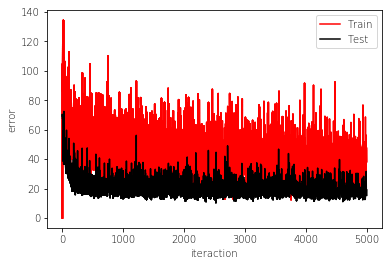

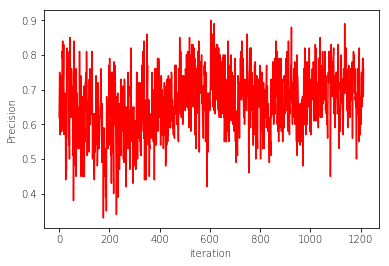

In [216]:
# Construire le réseau convolutif
[x, y_facile, y_difficile, y_pred_facile, y_pred_difficile, pkeep, step, cout_facile, cout_difficile, optimizer_facile, optimizer_difficile, init] = construire_reseau()    
# Ouvrir une session de calcul
sess = tf.Session()

vec_permutation_50000 = np.random.permutation(50000)
vec_permutation_10000 = np.random.permutation(10000)
X_train_perm = X_train[vec_permutation_50000, :, :, :]
Y_train_perm = classify_animal_object(Y_train[vec_permutation_50000])
X_test_perm = X_test[vec_permutation_10000, :, :, :]
Y_test_perm_bin = classify_animal_object(Y_test[vec_permutation_10000])    
# Entrainer le réseau
couts = entrainer_reseau_facile(X1=X_train_perm, Y1=Y_train_perm, sess=sess,
                                cout_facile=cout_facile, train_step_facile=optimizer_facile, 
                                init=init, params=hyperp,y_pred=y_pred_facile,X_test_task=X_test_perm,
                                Y_test_task=Y_test_perm_bin)
    
# Calculer la precision


## Partie 5: Définition de la tâche difficile

### la tache difficile est entrainer le réseau pré-entrainé à  classifier les 10 différents types d’image

In [217]:
def entrainer_reseau_dificile(X1, Y1, sess, cout_difficile, optimizer_difficile, 
                              init, params,y_pred,X_test_task,Y_test_task):

                
    batch_ys_test_1h = trasform_1h(Y=Y_test_task)            
    batch_ys_test_1h = np.reshape(batch_ys_test_1h,[-1,10])
    
   

    error_train =[]
    error_test=[]
    # Définir les cycles d'entraînement
    couts = []
    trans_batch = np.zeros([params['taille_batch'],32,32,3])
    i_c =0
    cout_actuel = 0
    precisions=[]
    for iter in range( params['nb_iterations'] ):
        cout_moyen  = 0.
        total_batch = int( X1.shape[0]/params['taille_batch'] )

        # itérer sur l'ensemble des batchesprecision:{}".format(cout_moyen,tester_reseau(sess,y_pred,batch_xs,batch_ys))
        for i in range(total_batch):
           
            
            debut_batch = i*params['taille_batch']
            fin_batch   = debut_batch + params['taille_batch']
            batch_xs    = np.reshape( X1[debut_batch:fin_batch, :], [-1, 32, 32, 3] )
           
            batch_ys    = Y1[debut_batch:fin_batch]
            batch_ys_1h = trasform_1h(Y=batch_ys)
            batch_ys_1h = np.reshape(batch_ys_1h,[-1,10])
            #print(batch_ys_1h)
            # Lancer l'optimisation (backprop) et en calculer le cout 
            entrainer = lambda train_step_dificile, cout_difficile ,x_t, y_1h,params,step: sess.run([train_step_dificile, cout_difficile], feed_dict={x: x_t, y_difficile: batch_ys_1h, 
                                                              pkeep:params['p_keep'], step:iter})
            c = executer_fonction_augmentation(batch_xs,entrainer,optimizer_difficile,cout_difficile,batch_ys_1h,params,step,cout_actuel)
            cout_actuel = c
        # print(">>> cout {}      ".format(c),end='\r')
            print(">>>iteraction{} batch:{}/{} cout:{} ".
                  format(iter,i,total_batch,c),end='\r')
            if np.random.random() <0.25:
                i_choice = np.random.choice(X_test_task.shape[0],size=100)
                precisions += [tester_reseau(sess,y_pred,X_test_task[i_choice],Y_test_task[i_choice])]          
        
            error_train +=[c]
            cout_test = sess.run(cout_difficile, feed_dict={x:X_test_task[1:100]/255 , y_difficile: batch_ys_test_1h[1:100],pkeep:1, step:iter})
            error_test += [cout_test]
        train, = plt.plot(list(range(len(error_train))), error_train, 'r')
        test, = plt.plot(list(range(len(error_test))), error_test, 'k')
        # Afficher le cout à chaque itération
       # if ( (iter+1) % params['pas_affichage'] ) == 0:
           # print("Iteration:", '%04d' % (iter+1), "cout=", "{:.9f} precision:{}".format(cout_moyen,tester_reseau(sess,y_pred,batch_xs,batch_ys)))

    train.set_label('Train')
    test.set_label('Test')
    plt.xlabel("iteraction")
    plt.ylabel("error")
    plt.legend()
    plt.show()
    prec, = plt.plot(list(range(len(precisions))), precisions, 'r')
    prec.set_label('Precision')
    plt.xlabel("iteration")
    plt.ylabel("Precision")
    plt.show()
    #print("Optimisation complétée!")
    return error_train

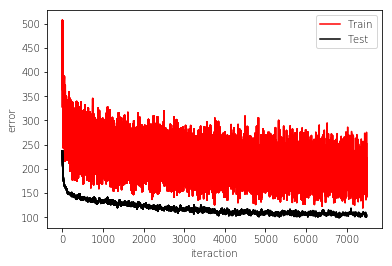

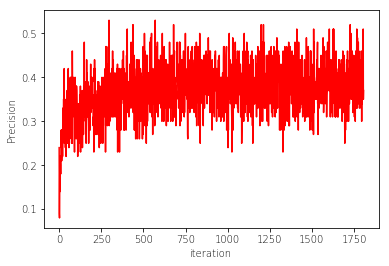

In [218]:
hyperp = {'nb_iterations':15, 'taille_batch':100, 'pas_affichage':1, 'p_keep':0.75}
vec_permutation_50000 = np.random.permutation(X_train.shape[0])
vec_permutation_10000 = np.random.permutation(X_test.shape[0])
X_train_perm = X_train[vec_permutation_50000, :, :, :]
Y_train_perm = Y_train[vec_permutation_50000]
X_test_perm = X_test[vec_permutation_10000, :, :, :]
Y_test_perm = Y_test[vec_permutation_10000]    
# Entrainer le réseau
couts = entrainer_reseau_dificile(X1=X_train_perm, Y1=Y_train_perm, sess=sess,
                                cout_difficile=cout_difficile, optimizer_difficile=optimizer_difficile, 
                                init=init, params=hyperp,y_pred=y_pred_difficile,X_test_task=X_test_perm,
                                Y_test_task=Y_test_perm)

## Partie 6: Entrainement et monitoring de l'erreur de test

In [219]:


precision = tester_reseau(sess, y_pred_difficile, X_test/255, Y_test)
precision

0.6163